Задание 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = pd.read_excel('test_case_data_analyst.xlsx', 
                     usecols=['is_trial_period', 'purchase_date', 'user_id'])
data.head()

,is_trial_period,purchase_date,user_id
0,False,2020-02-19,9484222
1,False,2020-02-17,9422402
2,False,2020-02-18,4997991
3,False,2020-02-18,9455582
4,False,2020-02-16,8803657


In [3]:
data.drop_duplicates(inplace=True)
print("period:" ,(data.purchase_date.max() - data.purchase_date.min()).days, "days")

period: 50 days


In [4]:
data.sort_values(by=["user_id","purchase_date"], inplace = True)

data.reset_index(inplace=True, drop=True)

data = data[data.is_trial_period == False].drop(columns="is_trial_period")

data['amount'] = 4.99

data.head()

,purchase_date,user_id,amount
1,2020-02-10,404,4.99
4,2020-02-03,9010,4.99
5,2020-02-10,9010,4.99
6,2020-02-17,9010,4.99
9,2020-01-27,23403,4.99


In [5]:
data_groupby_user = data.groupby(by = ["user_id"]).agg({"purchase_date": "min", "amount": ["sum","count"]})
data_groupby_user.reset_index(inplace = True)

data_groupby_user.columns = ["user_id", "first_date", "total_amount", "trasactions"]

data_groupby_user['cohort'] = data_groupby_user["first_date"].dt.strftime('%V').astype('int')

In [6]:
# текущий LTV
for i in range(1, 8):
    print(f"LTV {i}:", np.round(data_groupby_user[data_groupby_user.cohort == i].total_amount.sum() / \
          len(data_groupby_user[data_groupby_user.cohort == i]), 2), "USD")

LTV 1: 19.96 USD
LTV 2: 20.91 USD
LTV 3: 18.52 USD
LTV 4: 15.61 USD
LTV 5: 12.61 USD
LTV 6: 9.81 USD
LTV 7: 6.63 USD


При далшейшем сборе статистики LTV каждой из кагорт будет увеличиваться,
пока в кагорте совсем не останется активных пользователей.
По данному расчету мы можем сделать вывод, что LTV от клиента,
который совершил первый платеж, будет не менее 21 USD.

In [8]:
from sklearn.linear_model import LinearRegression

ltv = []
for i in range(2, 9):
    d = data_groupby_user[data_groupby_user.cohort == i].total_amount.sum() / \
          len(data_groupby_user[data_groupby_user.cohort == i])
    ltv = [np.round(d, 2)] + ltv
ltv

week = np.array(range(2,9)).reshape(-1, 1)

reg = LinearRegression().fit(week, ltv)

print("regression score:",reg.score(week, ltv))

regression score: 0.9964315228607629


In [12]:
print("LTV на пол года, 26 недель:", np.round(reg.predict([[26]])[0], 2), "USD")

LTV на пол года, 26 недель: 70.73 USD


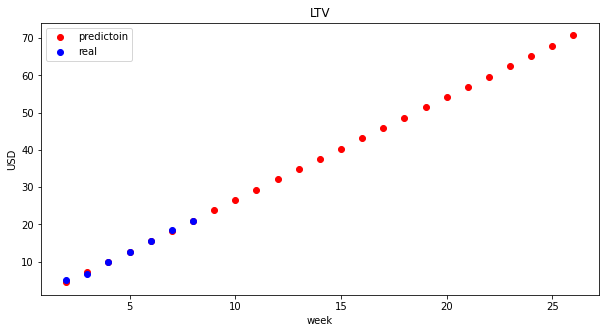

In [13]:
# график, отображающий кривую фактического LTV на фоне кривой прогнозируемого LTV
фоне кривой прогнозируемого LTV
plt.figure(figsize=(10,5))
plt.plot(np.array(range(2,27)), reg.predict(np.array(range(2,27)).reshape(-1, 1)), 'ro',label="predictoin")
plt.plot(np.array(range(2,9)), ltv, 'bo', label="real")
plt.title("LTV")
plt.xlabel("week")
plt.ylabel("USD")
plt.legend()
plt.show()

In [14]:
print("ROMI 4 week:", round((ltv[3] - 6) / 6 * 100), "%")
print("ROMI 6 month:", round((reg.predict([[26]])[0] - 6) / 6 * 100), "%")

ROMI 4 week: 110 %
ROMI 6 month: 1079 %


Задание 2

In [ ]:
# среднее значение по сумме продажи
SELECT SUM(sale_amount) / COUNT(1) mean
FROM orders

In [ ]:
# медиана по сумме продажи
SELECT sale_amount median
FROM orders
ORDER BY sale_amount
LIMIT 1 
OFFSET (SELECT COUNT(1) FROM orders) / 2;

In [ ]:
# поиск задублированных строк
SELECT transaction_id, datetime, amount, user_id, COUNT(*)
FROM purchases
GROUP BY transaction_id, datetime, amount, user_id
HAVING COUNT(*) > 1

In [ ]:
# воронка перехода из установки в оформление пробного периода 
# и в покупку платной версии приложения в разрезе стран

SELECT t1.country, t1.install, t2.trail, t3.purchase, 
t2.trail * 100 / t1.install conversion_rate_to_trial,
t3.purchase * 100 / t1.install conversion_rate_to_purchase
FROM 
  (SELECT country, count(*) install
  FROM events
  WHERE event_type = 'install'
  GROUP BY country) AS t1
LEFT JOIN
  (SELECT country, count(*) trail
  FROM events
  WHERE event_type = 'train'
  GROUP BY country) AS t2
ON t1.country=t2.country
LEFT JOIN
  (SELECT country, count(*) purchase
  FROM events
  WHERE event_type = 'purchase'
  GROUP BY country) AS t3
ON t1.country=t3.country;

Задание 3

Продуктовый менеджер сформировал гипотезу,  
что новая версия экрана продаж будет лучше перформить по сравнению со старой,   
в связи с тем, что на новом экране продаж более понятно описаны преимущества платной версии приложения.  
Продуктовый менеджер ожидает увеличение уровня конверсии из установки в покупку платной версии приложения.  
Приложение тем временем уже очень активно продвигается на рынке,  
каждый день привлекается в среднем по 30 000 новых пользователей,  
текущий уровень конверсии из установки в покупку 5%.  
Как бы вы предложили проверить данную гипотезу,  
какие инструменты и тесты бы использовали в процессе проверки?

1. Рандомно разбиваем новых пользователей на контрольную и тестовую группы.   
Пытаемся произвести разбивку таким образом, чтобы основные и важные для нас признаки  
(пол, возраст, страна и т.д.) были равномерно распределены между группами.  
1. Подсчитываем количество подписок в одной и в другой группах.  
На контрольную группу 30000 человек конверсия 5% соответсвует следующим цифрам [28500 - отказы, 1500 - подписки]  
Предположим, что в тестовой группе конверсия составила 5,5% [28350 - отказы, 1650 - подписки]
1. Так как вид рассматриваемой переменной качественный (пользователь либо купил подписку, либо нет),  
то мы будем использовать Критерий χ2 (хи-квадрат)  
1. Для рассчета используем библиотеку scipy

In [15]:
from scipy import stats


obs = np.array([[28500, 1500], [28350, 1650]])
chi2, p, dof, expected = stats.chi2_contingency(obs)

alpha = 0.05
if p > alpha:
    print('Принимаем гипотезу Н0, различий между выборками нет')
else:
    print('Отвергаем гипотезу Н0, статистически значимое различие')

print('P-уровень значимости:', np.round(p, 6))

Отвергаем гипотезу Н0, статистически значимое различие
P-уровень значимости: 0.006384


За 2 дня теста (60000 наблюдений) у нас получилось выявить статистически значимое различие   
при изменении конверсии на пол процента.